In [1]:
import os
join = os.path.join
import numpy as np
from glob import glob
import torch
from segment_anything.build_sam3D import sam_model_registry3D
from segment_anything.utils.transforms3D import ResizeLongestSide3D
from segment_anything import sam_model_registry
from tqdm import tqdm
import argparse
import SimpleITK as sitk
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchio as tio
import numpy as np
from collections import OrderedDict, defaultdict
import json
import pickle
import utils.data_loader 
import einops as E
import torch
Dataset_Union_ALL_Val = utils.data_loader.Dataset_Union_ALL_Val


In [2]:
# hardcode for juptyer notebook compatability

args = argparse.Namespace(
    test_data_path = '/home/t722s/Desktop/Datasets/BratsTestData/',
    checkpoint_path=  '',
    results_save_path='/home/t722s/Desktop/Sam-Med3DTest/evalBrats/',
    model='SAM-Med3D',
    seed=2023,
    dim = 3,
    crop_size = 128,
    data_type = 'Ts',
    split_num = 1,
    split_idx = 0,
)

points_path = os.path.join(args.results_save_path, 'prompts.pkl')

SEED = args.seed
print("set seed as", SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

if torch.cuda.is_available():
    torch.cuda.init()

# Obtain dataloaders
infer_transform = [
    tio.ToCanonical(),
    tio.CropOrPad(mask_name='points', target_shape=(args.crop_size,args.crop_size,args.crop_size)), # Will center the cropping/padding at the center of the bounding box of the clicks supplied.
]

test_dataset = Dataset_Union_ALL_Val(
    paths=args.test_data_path, 
    mode="Val", 
    dim = 3,
    label = 1,
    points_path = points_path,
    data_type=args.data_type, 
    transform=tio.Compose(infer_transform),
    threshold=0,
    split_num=args.split_num,
    split_idx=args.split_idx,
    pcc=False,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    sampler=None,
    batch_size=1, 
    shuffle=True
    )

set seed as 2023


In [3]:
image_paths = ['/home/t722s/Desktop/Datasets/BratsTestData/imagesTs/BraTS2021_01646.nii.gz']
label_paths = ['/home/t722s/Desktop/Datasets/BratsTestData/labelsTs/BraTS2021_01646.nii.gz']
dim = 3
label = 1

infer_transform = [
        tio.ToCanonical(),
        tio.CropOrPad(mask_name='points_mask', target_shape=(args.crop_size,args.crop_size,args.crop_size)), # Will center the cropping/padding at the center of the bounding box of the clicks supplied.
    ]

transform = tio.Compose(infer_transform)
transform = tio.CropOrPad(mask_name='points_mask', target_shape=(args.crop_size,args.crop_size,args.crop_size)), # Will center the cropping/padding at the center of the bounding box of the clicks supplied.

with open(points_path, 'rb') as f:
    points_dict = pickle.load(f)

index = 0

tio_image = tio.ScalarImage.from_sitk(sitk.ReadImage(image_paths[index]))


#### UNDER CONSTRUCTION
# Load in points for this image and change to a mask to be usable by torchio
points = points_dict[os.path.basename(image_paths[index])][label][str(dim) + 'D']
points_mask = np.zeros(shape = (tio_image.shape[3], tio_image.shape[2], tio_image.shape[1])) # Skip the color channel for now; reintroduce in label_map definition. Reverse order since sitk uses WHD while numpy uses DHW
points_mask[*points.T] = 1
points_mask = E.rearrange(points_mask, pattern = 'x y z -> z y x') # Rearrange back to sitk WHD

points_mask = tio.LabelMap(tensor = torch.from_numpy(points_mask).float().unsqueeze(0), affine = tio_image.affine)

subject = tio.Subject(
    image = tio_image,
    points_mask = points_mask,
    label = tio.ScalarImage.from_sitk(sitk.ReadImage(label_paths[index])),
)

if '/ct_' in image_paths[index]:
    subject = tio.Clamp(-1000,1000)(subject)

# if transform:
#     try:
#         subject = transform(subject)
#     except:
#         print(image_paths[index])


In [4]:
def _bbox_mask(mask_volume: np.ndarray):
        """Return 6 coordinates of a 3D bounding box from a given mask.

        Taken from `this SO question <https://stackoverflow.com/questions/31400769/bounding-box-of-numpy-array>`_.

        Args:
            mask_volume: 3D NumPy array.
        """  # noqa: B950
        i_any = np.any(mask_volume, axis=(1, 2))
        j_any = np.any(mask_volume, axis=(0, 2))
        k_any = np.any(mask_volume, axis=(0, 1))
        i_min, i_max = np.where(i_any)[0][[0, -1]]
        j_min, j_max = np.where(j_any)[0][[0, -1]]
        k_min, k_max = np.where(k_any)[0][[0, -1]]
        bb_min = np.array([i_min, j_min, k_min])
        bb_max = np.array([i_max, j_max, k_max]) + 1
        return bb_min, bb_max

def getCroppingParams(subject, mask_name = 'points_mask', target_shape=None):
    '''Function to get the cropping and padding parameters used in an apply_transform call of torchio.CropOrPad, which can then be used to invert the transformation later on'''

    mask_data = subject[mask_name].data.bool().numpy()

    subject_shape = subject.spatial_shape
    bb_min, bb_max = _bbox_mask(mask_data[0])
    center_mask = np.mean((bb_min, bb_max), axis=0)
    padding = []
    cropping = []

    for dim in range(3):
        target_dim = target_shape[dim]
        center_dim = center_mask[dim]
        subject_dim = subject_shape[dim]

        center_on_index = not (center_dim % 1)
        target_even = not (target_dim % 2)

        # Approximation when the center cannot be computed exactly
        # The output will be off by half a voxel, but this is just an
        # implementation detail
        if target_even ^ center_on_index:
            center_dim -= 0.5

        begin = center_dim - target_dim / 2
        if begin >= 0:
            crop_ini = begin
            pad_ini = 0
        else:
            crop_ini = 0
            pad_ini = -begin

        end = center_dim + target_dim / 2
        if end <= subject_dim:
            crop_fin = subject_dim - end
            pad_fin = 0
        else:
            crop_fin = 0
            pad_fin = end - subject_dim

        padding.extend([pad_ini, pad_fin])
        cropping.extend([crop_ini, crop_fin])
    
    # Conversion for SimpleITK compatibility
    padding_array = np.asarray(padding, dtype=int)
    cropping_array = np.asarray(cropping, dtype=int)
    if padding_array.any():
        padding_params = tuple(padding_array.tolist())
    else:
        padding_params = None
    if cropping_array.any():
        cropping_params = tuple(cropping_array.tolist())
    else:
        cropping_params = None
    return padding_params, cropping_params  # type: ignore[return-value]

def _crop(image, cropping_params):

    low = cropping_params[::2]
    high = cropping_params[1::2]
    index_ini = low
    index_fin = np.array(image.shape)[1:] - high
    i0, j0, k0 = index_ini
    i1, j1, k1 = index_fin
    image_cropped = image[:, i0:i1, j0:j1, k0:k1]

    return(image_cropped)

def _pad(image, padding_params):
    paddings = (0, 0), padding_params[:2], padding_params[2:4], padding_params[4:]
    image_padded = np.pad(image, paddings, mode = 'constant', constant_values = 0)  

    return(image_padded)
def invertCropOrPad(image, padding_params, cropping_params):
    im_inv = image.numpy()
    im_inv = _crop(im_inv, padding_params)
    im_inv = _pad(im_inv, cropping_params)

    return(torch.from_numpy(im_inv))

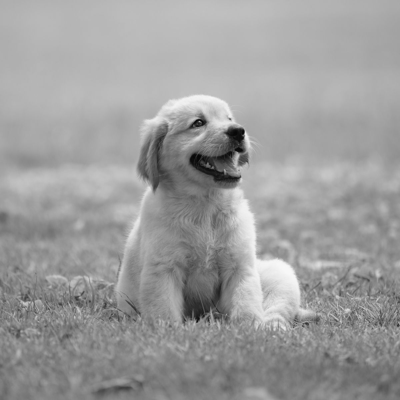

In [5]:
# Testing: crop/pad and revert for a test image
from PIL import Image
import torchvision.transforms as transforms
import torch
from IPython.display import display


# Get test image
image_path = '/home/t722s/Downloads/dog.jpg'
image_pil = Image.open(image_path)
image_pil = image_pil.convert('L')
image_pil = image_pil.resize((400, 400))

display(image_pil)

#image_pil.show()

# Get an appropriate one point point mask and stick it all in a tio subject

transform = transforms.ToTensor()  # Converts the image to a PyTorch tensor

image_tensor = transform(image_pil)
tio_image = tio.ScalarImage(tensor = image_tensor.unsqueeze(0))

points_mask = np.zeros(shape = (image_tensor.shape[2], image_tensor.shape[1])) # Skip the color channel for now; reintroduce in label_map definition. Reverse order since sitk uses xy while numpy uses yx

points_mask[*np.array([[399], [399]])] = 1
points_mask = points_mask.T # Rearrange back to sitk xy

points_mask = tio.LabelMap(tensor = torch.from_numpy(points_mask).float().unsqueeze(0).unsqueeze(0), affine = tio_image.affine)

subject = tio.Subject(
    image = tio_image,
    points_mask = points_mask
)


padding_params, cropping_params = getCroppingParams(subject, mask_name='points_mask', target_shape=(1,300,300))
padding_kwargs = {'padding_mode': 0}
if padding_params is not None:
    pad = tio.Pad(padding_params, **padding_kwargs)
    subject = pad(subject)  # type: ignore[assignment]
if cropping_params is not None:
    crop = tio.Crop(cropping_params)
    subject = crop(subject)  # type: ignore[assignment]


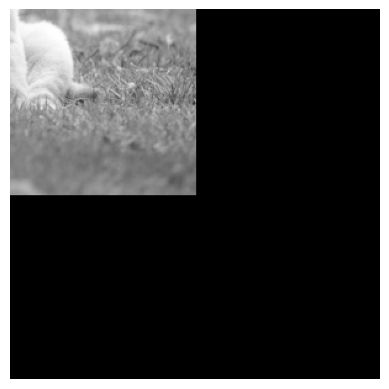

In [6]:
import matplotlib.pyplot as plt
im = subject['image'].data[0]
plt.imshow(im.permute(1, 2, 0), cmap='gray')  # PyTorch tensors are typically in (C, H, W) format, so we permute dimensions
plt.axis('off')  # Turn off the axis
plt.show()  # Display the image


In [17]:
image_tensor

tensor([[[0.6824, 0.6824, 0.6824,  ..., 0.6627, 0.6627, 0.6627],
         [0.6824, 0.6824, 0.6824,  ..., 0.6627, 0.6627, 0.6627],
         [0.6824, 0.6824, 0.6824,  ..., 0.6667, 0.6667, 0.6667],
         ...,
         [0.4275, 0.4196, 0.4235,  ..., 0.4549, 0.4471, 0.4471],
         [0.4235, 0.4196, 0.4196,  ..., 0.4667, 0.4588, 0.4588],
         [0.4196, 0.4157, 0.4157,  ..., 0.4627, 0.4627, 0.4627]]])

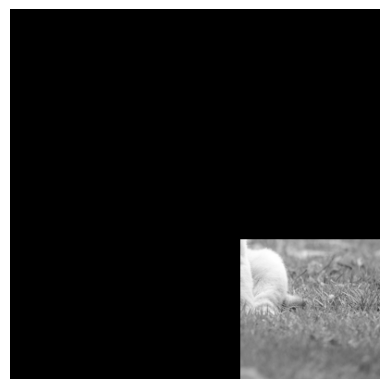

In [7]:
im = subject['image'].data
im_inv = invertCropOrPad(im, padding_params, cropping_params)


plt.imshow(im_inv[0].permute(1,2,0), cmap = 'grey')
plt.axis('off')
plt.show()

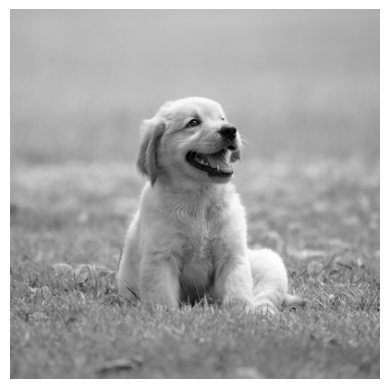

In [8]:
im_old = image_tensor.numpy()
plt.imshow(im_old.transpose(1,2,0), cmap = 'grey')
plt.axis('off')
plt.show()

In [9]:
_bbox_mask(im_inv[0].numpy())

(array([  0, 249, 249]), array([  1, 400, 400]))

In [35]:
np.all(im_inv.numpy()[0,0,249:,249:] == im_old[0,249:,249:])

True